In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [35]:
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# GPU device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [36]:
# get file name
testFileName = list()
trainFileNameClass0 = list()
trainFileNameClass1 = list()
os.chdir('/kaggle/input/nycu-ml-pattern-recognition-hw-4/released/test')
testFileName = os.listdir()
os.chdir('../train/class_0')
trainFileNameClass0 = os.listdir()
os.chdir('../class_1')
trainFileNameClass1 = os.listdir()
os.chdir('../../')
# test file name
testFileName[0], trainFileNameClass0[0], trainFileNameClass1[0]

('7c08c8c0-0064-40c3-a7cd-dda2b4043347.pkl',
 '32767294-e76e-485e-91a0-c2a123498e01.pkl',
 '3cc6a03d-7585-48f4-82cc-89448620b059.pkl')

In [37]:
def readData(filepath, filenamelist):
    FileExtensionRemove = []
    with open(filepath+filenamelist[0], 'rb') as f:
        data = np.array([pickle.load(f)])
    FileExtensionRemove.append(filenamelist[0][:-4])
    for filename in filenamelist[1:]:
        with open(filepath+filename, 'rb') as f:
            data = np.concatenate((data, np.array([pickle.load(f)])), axis=0)
        FileExtensionRemove.append(filename[:-4])
    return data, FileExtensionRemove

def DataPreprocess(trainX0, trainX1=None):
    # combine train data
    if trainX1 is None:
        trainX = trainX0
    else:
        trainX = np.concatenate((trainX0, trainX1))
    # Transform to 0 ~ 1
    trainX = trainX.astype('float32')
    trainX /= 255
    # To pytorch
    trainX = torch.from_numpy(trainX)
    if trainX1 is None:
        trainY = None
    else:
        trainY = torch.concatenate((torch.zeros((trainX0.shape[0],1)), 
                                    torch.ones((trainX1.shape[0],1))))
    return trainX, trainY

In [38]:
DataSizeBatch = 25
train_loader = []
val_loader = []
for i in range(int(len(trainFileNameClass0)/DataSizeBatch)):
    print("read batch", i)
    startIndex = i * DataSizeBatch
    trainX0, _ = readData('train/class_0/', trainFileNameClass0[startIndex:startIndex + DataSizeBatch])
    trainX1, _ = readData('train/class_1/', trainFileNameClass1[startIndex:startIndex + DataSizeBatch])
    
    trainX, trainY = DataPreprocess(trainX0, trainX1)
    # Split data into train and validation sets
    trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2)
    
    # Create DataLoader for batching
    train_dataset = TensorDataset(trainX, trainY)
    val_dataset = TensorDataset(valX, valY)

    train_loader.append(DataLoader(train_dataset, batch_size=4, shuffle=True))
    val_loader.append(DataLoader(val_dataset, batch_size=4, shuffle=False))
    

# Try to merge dataloader
#trainLoader = DataLoader(ConcatDataset([dsa, dsb]))
#valLoader = DataLoader(ConcatDataset([dsa, dsb]))


read batch 0
read batch 1
read batch 2
read batch 3
read batch 4
read batch 5


In [39]:
# Feature extraction model using AlexNet
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        base_model = models.alexnet(weights='IMAGENET1K_V1')
        self.feature_extractor = nn.Sequential(
            *list(base_model.features), 
            # nn.Dropout(p=0.2),
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            *list(base_model.classifier[:-1])
        )
    
    def forward(self, x):
        x = self.feature_extractor(x)
        return x

In [40]:
# Number of tiles per bag
FEATURE_DIM = 4096
# MIL model
class MILModel(nn.Module):
    def __init__(self):
        super(MILModel, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = nn.Linear(FEATURE_DIM, 1)
    
    def forward(self, x):
        batch_size = x.size(0)
        num_tiles = x.size(1)
        x = x.view(-1, 3, 128, 128)
        features = self.feature_extractor(x)
        features = features.view(batch_size, num_tiles, -1)
        aggregated_features, _ = torch.max(features, dim=1)
        logits = self.classifier(aggregated_features)
        output = torch.sigmoid(logits)
        
        return output
    
    def predict(self, x):
        with torch.no_grad():
            ypred_prob = self(x)
            ypred = ypred_prob.clone().detach()
            ypred[ypred < 0.5] = 0
            ypred[ypred >= 0.5] = 1
            return ypred_prob, ypred

In [41]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Initialize the model
model = MILModel().to(device)
print(model)

# Define loss and optimizer
criterion = nn.BCELoss()
# SGD in Case1 not well (predict prob is very close +-0.1?)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

MILModel(
  (feature_extractor): FeatureExtractor(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (13): AdaptiveAvgPool2d(output_size=(6, 6))
      (14): Flatten(start_dim=1, end_dim=-1)
      (15): D

In [42]:
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for tl in train_loader:
        for i, (inputs, targets) in enumerate(tl):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_train_loss = running_loss / (len(tl) * len(train_loader))
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_loss = 0.0
    for vl in val_loader:
        with torch.no_grad():
            for inputs, targets in vl:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
    avg_val_loss = val_loss / (len(vl) * len(val_loader))
    val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

print('Training finished.')

Epoch [1/10], Train Loss: 0.7878, Val Loss: 0.6994
Epoch [2/10], Train Loss: 0.7182, Val Loss: 0.6861
Epoch [3/10], Train Loss: 0.7056, Val Loss: 0.6936
Epoch [4/10], Train Loss: 0.7141, Val Loss: 0.6842
Epoch [5/10], Train Loss: 0.6888, Val Loss: 0.6858
Epoch [6/10], Train Loss: 0.6556, Val Loss: 0.6865
Epoch [7/10], Train Loss: 0.6149, Val Loss: 0.7326
Epoch [8/10], Train Loss: 0.6171, Val Loss: 0.7308
Epoch [9/10], Train Loss: 0.5197, Val Loss: 0.7290
Epoch [10/10], Train Loss: 0.4788, Val Loss: 0.8785
Training finished.


In [43]:
# Save model weight
torch.save(model.state_dict(), "/kaggle/working/alexnet-weight.pth")

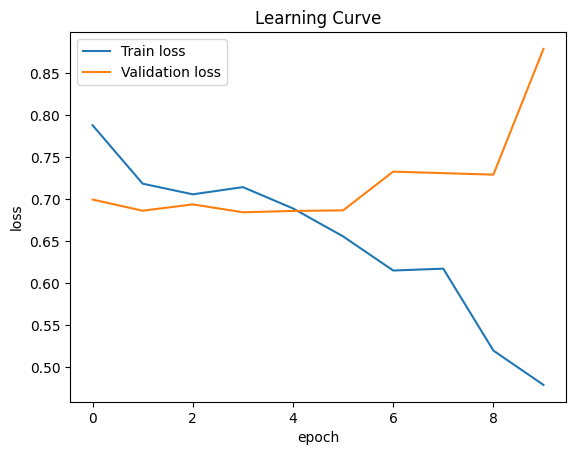

In [44]:
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

train acc: tensor(0.9750, device='cuda:0')


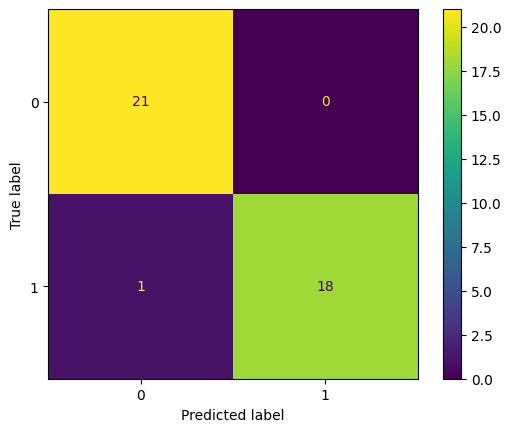

In [45]:
# train test
prob, lab = model.predict(trainX.to(device))
print("train acc:",1 - torch.sum(torch.abs(lab.to(device) - trainY.to(device)))/lab.shape[0])

cm = confusion_matrix(trainY.T[0], lab.cpu().T[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

val acc: tensor(0.6000, device='cuda:0')


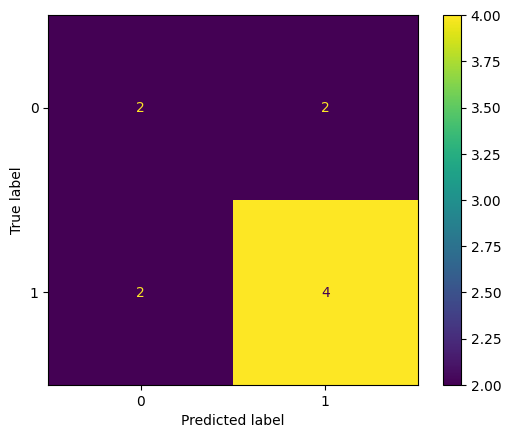

In [46]:
# train test
prob, lab = model.predict(valX.to(device))
print("val acc:", 1 -  torch.sum(torch.abs(lab.to(device) - valY.to(device)))/lab.shape[0])

cm = confusion_matrix(valY.T[0], lab.cpu().T[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [48]:
# load test data and predict

predictArray = np.array([])

FileExtensionRemove = []
for i in range(int(len(testFileName)/DataSizeBatch)):
    print("Predict Batch ", i)
    
    startIndex = i * DataSizeBatch
    testX, Name = readData('test/', testFileName[startIndex:startIndex + DataSizeBatch])
    FileExtensionRemove += Name
    testX, _ = DataPreprocess(testX)
    
    pred_prob, pred_label = model.predict(testX.to(device))
    predictArray = np.concatenate((predictArray, pred_label.cpu().detach().numpy().T[0]))

predictArray = predictArray.astype(np.int64)

Predict Batch  0
Predict Batch  1
Predict Batch  2
Predict Batch  3
Predict Batch  4
Predict Batch  5
Predict Batch  6
Predict Batch  7


In [49]:
# to pandas
submission = pd.DataFrame()
submission["image_id"] = FileExtensionRemove
submission["y_pred"] = predictArray

In [50]:
submission

,image_id,y_pred
0,7c08c8c0-0064-40c3-a7cd-dda2b4043347,1
1,cb206033-5968-44f9-bfc8-dab33bb57bae,1
2,355823c5-bc8e-4352-8892-10bf14ce866a,1
3,7f6d455e-47a0-4529-954d-0cc432f63d50,1
4,7a2304f3-f864-4c16-b683-468d87808661,1
...,...,...
195,4e4aef19-6408-46d9-9573-f8948c640e9d,1
196,9ea39c64-6d6c-4ff6-ae08-71ebca779275,1
197,e072b562-f2ef-42f7-8c60-ecf744a9469e,1
198,80b8987c-70c4-4274-9b46-893e3877a8cd,0


In [51]:
submission.to_csv('/kaggle/working/submission.csv', index = None)

In [52]:
print(pred_prob, pred_label)

tensor([[0.6161],
        [0.9940],
        [0.0398],
        [0.6087],
        [0.6142],
        [0.6578],
        [0.3569],
        [0.8158],
        [0.6599],
        [0.2890],
        [0.4443],
        [0.4185],
        [0.4590],
        [0.6934],
        [0.4324],
        [0.5636],
        [0.8698],
        [0.3758],
        [0.1375],
        [0.2016],
        [0.6015],
        [0.8960],
        [0.7706],
        [0.3956],
        [0.4264]], device='cuda:0') tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.]], device='cuda:0')
